In [13]:
import sys, platform, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline
# import seaborn as sns

# Global definition of matplotlib plots appearance

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10             # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.2
plt.rcParams['figure.dpi'] = 400            #  figure dimension in dpi

In [14]:
camb_installation_path = './../' 
camb_path = os.path.realpath(os.path.join(os.getcwd(),camb_installation_path))
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower

Basic flags and parameters

In [15]:
common_config ={
                'EFTCAMB_skip_RGR': True,
                'EFTCAMB_skip_stability': True,
                'model_background_num_points': 10000,
                'model_background_a_ini': 1e-8,
                'EFTCAMB_turn_on_time': 1e-8,
                'feedback_level'             : 0
                }

cosmo_pars = {
    'ombh2': 0.0226,
    'omch2': 0.12,
    'H0': 70,
    'tau':0.055,
    'ns': 0.965,
    'As': 2.1e-09,
    # 'num_massive_neutrinos': 1,
    # 'mnu': 0.06,
    'num_massive_neutrinos': 0,
    'mnu': 0,
    'nnu': 3.044,
}

SCG model within EFT structure

In [16]:
# base parameters for all SCG models
base_params_SCG = {
    'EFTflag': 4,
    'FullMappingEFTmodel': 6,
    'want_debug'        : False,
}

# specific parameters for each SCG model
model_specifics_SCG = {
    "SCGEFTM1": {'Scaling_Cubic_beta1': 100, 'Scaling_Cubic_beta2': 0.7, 'Scaling_Cubic_A': -0.3, 'Scaling_Cubic_lambda': 154},
    "SCGEFTM2": {'Scaling_Cubic_beta1': 100, 'Scaling_Cubic_beta2': 0.7, 'Scaling_Cubic_A': 0.09, 'Scaling_Cubic_lambda': -8},
    "SCGEFTM3": {'Scaling_Cubic_beta1': 100, 'Scaling_Cubic_beta2': 0.7, 'Scaling_Cubic_A': -0.28, 'Scaling_Cubic_lambda': 148.3},
    "SCGEFTM4": {'Scaling_Cubic_beta1': 100, 'Scaling_Cubic_beta2': 2.5, 'Scaling_Cubic_A': -1, 'Scaling_Cubic_lambda': 150}
}

# combine base parameters with model-specific parameters
models_SCG = {}
for name, params in model_specifics_SCG.items():
    models_SCG[name] = {**base_params_SCG, **params, **common_config}

In [17]:
# find the initial phidot_ini and V1 (Horndeski_param5) based on the tracking solution
# this makes sure we are computing the same model with the same paramters in the Horndeski module

V1bp, dphi = [], []

for name, SCGEFT_params in zip(models_SCG.keys(), models_SCG.values()):
    params = {**SCGEFT_params, **cosmo_pars}
    pars_SCG_EFT = camb.set_params(**params)
    results = camb.get_results(pars_SCG_EFT)
    a_ini = common_config['model_background_a_ini']
    H_ini = results.h_of_z(1/a_ini-1) # in Mpc^{-1} units

    a = SCGEFT_params['Scaling_Cubic_A']
    b1 = SCGEFT_params['Scaling_Cubic_beta1']
    lmd = SCGEFT_params['Scaling_Cubic_lambda']
    y10 = np.sqrt(12+6*a*(3*b1-4*lmd))/3/b1
    x10 = 2*np.sqrt(6)/3/b1
    V1bp.append(3 * (y10 * H_ini) ** 2)
    dphi.append(np.sqrt(6) * H_ini * x10 * common_config['model_background_a_ini'])

Horndeski Module

In [ ]:
base_params_HEFT = {
                'EFTflag' :5,
                'Horndeski_model': 6, 
                'Horndeski_parameter_number': 6, 
                'Horndeski_model_specific_ic': False,
                'Horndeski_evolve_hubble': False,
                'Horndeski_phi_ini': 0.,
                'EFTCAMB_evolve_delta_phi': False,
                # if evolving delta_phi equations, set IntTolBoost >= 4 to have accurate result for M2
                # 'EFTCAMB_evolve_delta_phi': True, 
                'EFTCAMB_evolve_metric_h': False,
                'EFTCAMB_use_background': True,
            }

model_specifics_HEFT = {
    "HEFTM1": {'Horndeski_param1': models_SCG["SCGEFTM1"]['Scaling_Cubic_A'],
             'Horndeski_param2': models_SCG["SCGEFTM1"]['Scaling_Cubic_beta1'],
             'Horndeski_param3': models_SCG["SCGEFTM1"]['Scaling_Cubic_beta2'],
             'Horndeski_param4': models_SCG["SCGEFTM1"]['Scaling_Cubic_lambda'],
             'Horndeski_param5': V1bp[0],
             'Horndeski_phidot_ini': dphi[0],
             },
    "HEFTM2": {'Horndeski_param1': models_SCG["SCGEFTM2"]['Scaling_Cubic_A'],
             'Horndeski_param2': models_SCG["SCGEFTM2"]['Scaling_Cubic_beta1'],
             'Horndeski_param3': models_SCG["SCGEFTM2"]['Scaling_Cubic_beta2'],
             'Horndeski_param4': models_SCG["SCGEFTM2"]['Scaling_Cubic_lambda'],
             'Horndeski_param5': V1bp[1],
             'Horndeski_phidot_ini': dphi[1],
             },
    "HEFTM3": {'Horndeski_param1': models_SCG["SCGEFTM3"]['Scaling_Cubic_A'],
             'Horndeski_param2': models_SCG["SCGEFTM3"]['Scaling_Cubic_beta1'],
             'Horndeski_param3': models_SCG["SCGEFTM3"]['Scaling_Cubic_beta2'],
             'Horndeski_param4': models_SCG["SCGEFTM3"]['Scaling_Cubic_lambda'],
             'Horndeski_param5': V1bp[2],
             'Horndeski_phidot_ini': dphi[2],
             },
    "HEFTM4": {'Horndeski_param1': models_SCG["SCGEFTM4"]['Scaling_Cubic_A'],
             'Horndeski_param2': models_SCG["SCGEFTM4"]['Scaling_Cubic_beta1'],
             'Horndeski_param3': models_SCG["SCGEFTM4"]['Scaling_Cubic_beta2'],
             'Horndeski_param4': models_SCG["SCGEFTM4"]['Scaling_Cubic_lambda'],
             'Horndeski_param5': V1bp[3],
             'Horndeski_phidot_ini': dphi[3],
             },
            }

models_HEFT = {}
for name, params in model_specifics_HEFT.items():
    models_HEFT[name] = {**base_params_HEFT, **params, **common_config}

In [19]:
# this shoots for V2 (Horndeski_param6)
def shoot(lmd, params):
    par = params.copy()
    par['feedback_level'] = 0
    par['Horndeski_shooting'] = True
    par['Horndeski_param6'] = lmd
    cp = camb.set_params(**par)
    rl = camb.get_background(cp, no_thermo=True)
    return rl.Params.EFTCAMB_parameter_cache.h0 / par['H0'] - 1

Compare Some Background Values

/var/folders/lh/nm1wgy6105g2dccjrlc621880000gn/T/ipykernel_29123/3125317452.py:60: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  a.set_xlim([0, 1e2])
/var/folders/lh/nm1wgy6105g2dccjrlc621880000gn/T/ipykernel_29123/3125317452.py:64: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  a.set_xlim([0, 1e2])


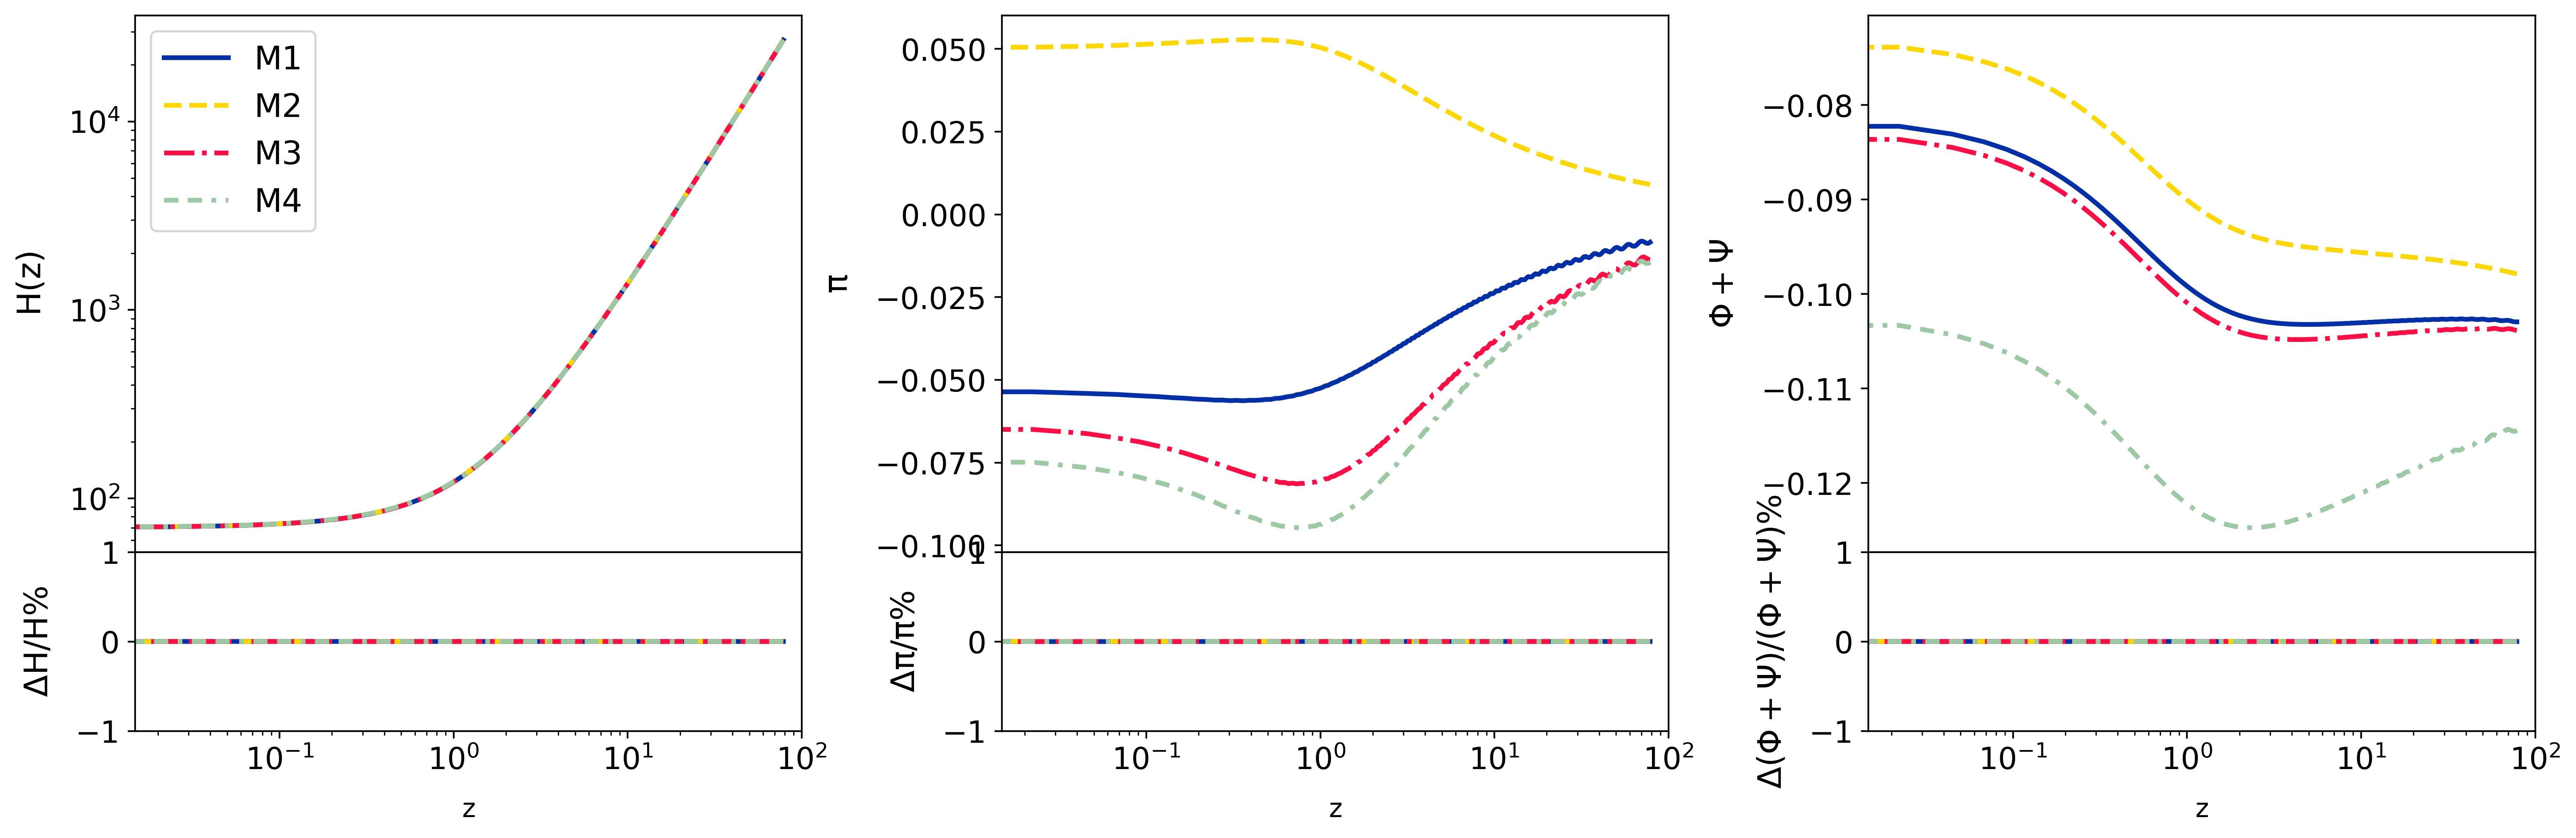

In [20]:
colors = ['#002FA7', '#FFD700',"#FF0D45", '#9CC9A3']
DE_labels = ['M1', 'M2', 'M3', 'M4']
linestyles = ['-', '--', '-.', (0, (3, 2, 3, 2, 1, 2))]
a_vec = np.logspace(-1.9,0, num=200)
z_vec = 1/a_vec - 1

fig, ax = plt.subplots(2, 3, figsize=(20, 6), sharex=True, height_ratios=[3, 1])
plt.subplots_adjust(hspace=0.0, wspace=0.3)

for (name_HEFT, HEFT_params), (name_SCG, SCGEFT_params), color, label, ls in\
        zip(models_HEFT.items(), models_SCG.items(), colors, DE_labels, linestyles):

    params_HEFT = {**HEFT_params, **cosmo_pars, **common_config}
    params_SCG = {**SCGEFT_params, **cosmo_pars, **common_config}

    rlt = root_scalar(shoot, args=(params_HEFT,), rtol=1e-4, bracket=[0, 1e6], x0=3e4, method="brentq")
    params_HEFT['Horndeski_param6'] = rlt.root
    pars_HEFT = camb.set_params(**params_HEFT)
    # pars_HEFT.Accuracy.IntTolBoost = 4
    results_HEFT = camb.get_results(pars_HEFT)
    nms_HEFT, vls_HEFT = pars_HEFT.EFTCAMB.get_scale_evolution(results_HEFT, 0.1, a_vec)

    pars_SCG = camb.set_params(**params_SCG)
    results_SCG = camb.get_results(pars_SCG)
    nms_SCG, vls_SCG = pars_SCG.EFTCAMB.get_scale_evolution(results_SCG, 0.1, a_vec)

    H_HEFT = results_HEFT.hubble_parameter(z_vec)
    Phi_HEFT = vls_HEFT['Phi'][0]
    Psi_HEFT = vls_HEFT['Psi'][0]
    pi_HEFT = vls_HEFT['pi'][0]
    PhiPsi_HEFT = (Phi_HEFT + Psi_HEFT)

    H_SCG = results_SCG.hubble_parameter(z_vec)
    Phi_SCG = vls_SCG['Phi'][0]
    Psi_SCG = vls_SCG['Psi'][0]
    pi_SCG = vls_SCG['pi'][0]
    PhiPsi_SCG = (Phi_SCG + Psi_SCG)

    ax[0,0].plot(z_vec, H_HEFT, color=color, ls=ls, label=label)
    ax[0,1].plot(z_vec, pi_HEFT, color=color, ls=ls, label=label)
    ax[0,2].plot(z_vec, PhiPsi_HEFT, color=color, ls=ls, label=label)
    ax[1,0].plot(z_vec, (H_HEFT - H_SCG )/H_SCG*100, color=color, ls=ls)
    ax[1,1].plot(z_vec, (pi_HEFT - pi_SCG)/pi_SCG*100, color=color, ls=ls)
    ax[1,2].plot(z_vec, (PhiPsi_HEFT - PhiPsi_SCG)/PhiPsi_SCG*100, color=color, ls=ls)

ax[0,0].set_ylabel(r'$H(z)$', fontsize=15)
ax[0,1].set_ylabel(r'$\pi$', fontsize=15)
ax[0,2].set_ylabel(r'$\Phi + \Psi$', fontsize=15)
ax[1,0].set_ylabel(r'$\Delta H/H$%', fontsize=15)
ax[1,1].set_ylabel(r'$\Delta \pi/\pi$%', fontsize=15)
ax[1,2].set_ylabel(r'$\Delta (\Phi + \Psi)/(\Phi + \Psi)$%', fontsize=15)
ax[1,0].set_xlabel(r'$z$', fontsize=15)
ax[1,1].set_xlabel(r'$z$', fontsize=15)
ax[1,2].set_xlabel(r'$z$', fontsize=15)
ax[0,0].legend()
ax[0,0].set_yscale('log')

for a in ax[0,:]:
    a.set_xscale('log')
    a.set_xlim([0, 1e2])
for a in ax[1,:]:
    a.set_xlabel(r'$z$', fontsize=12)
    a.set_xscale('log')
    a.set_xlim([0, 1e2])
    a.set_ylim([-1, 1])

Compare the CMB power spectrum

/var/folders/lh/nm1wgy6105g2dccjrlc621880000gn/T/ipykernel_29123/1382016389.py:62: RuntimeWarning: invalid value encountered in divide
  axes[1][0].plot(l, (totCL_HEFT[:, 0] - totCL_SCG[:, 0]) / totCL_SCG[:, 0] * 100, color=color, ls=ls)
/var/folders/lh/nm1wgy6105g2dccjrlc621880000gn/T/ipykernel_29123/1382016389.py:77: RuntimeWarning: invalid value encountered in divide
  axes[1][1].plot(l, (totCL_HEFT[:, 1] - totCL_SCG[:, 1]) / totCL_SCG[:, 1] * 100, color=color, ls=ls)
/var/folders/lh/nm1wgy6105g2dccjrlc621880000gn/T/ipykernel_29123/1382016389.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


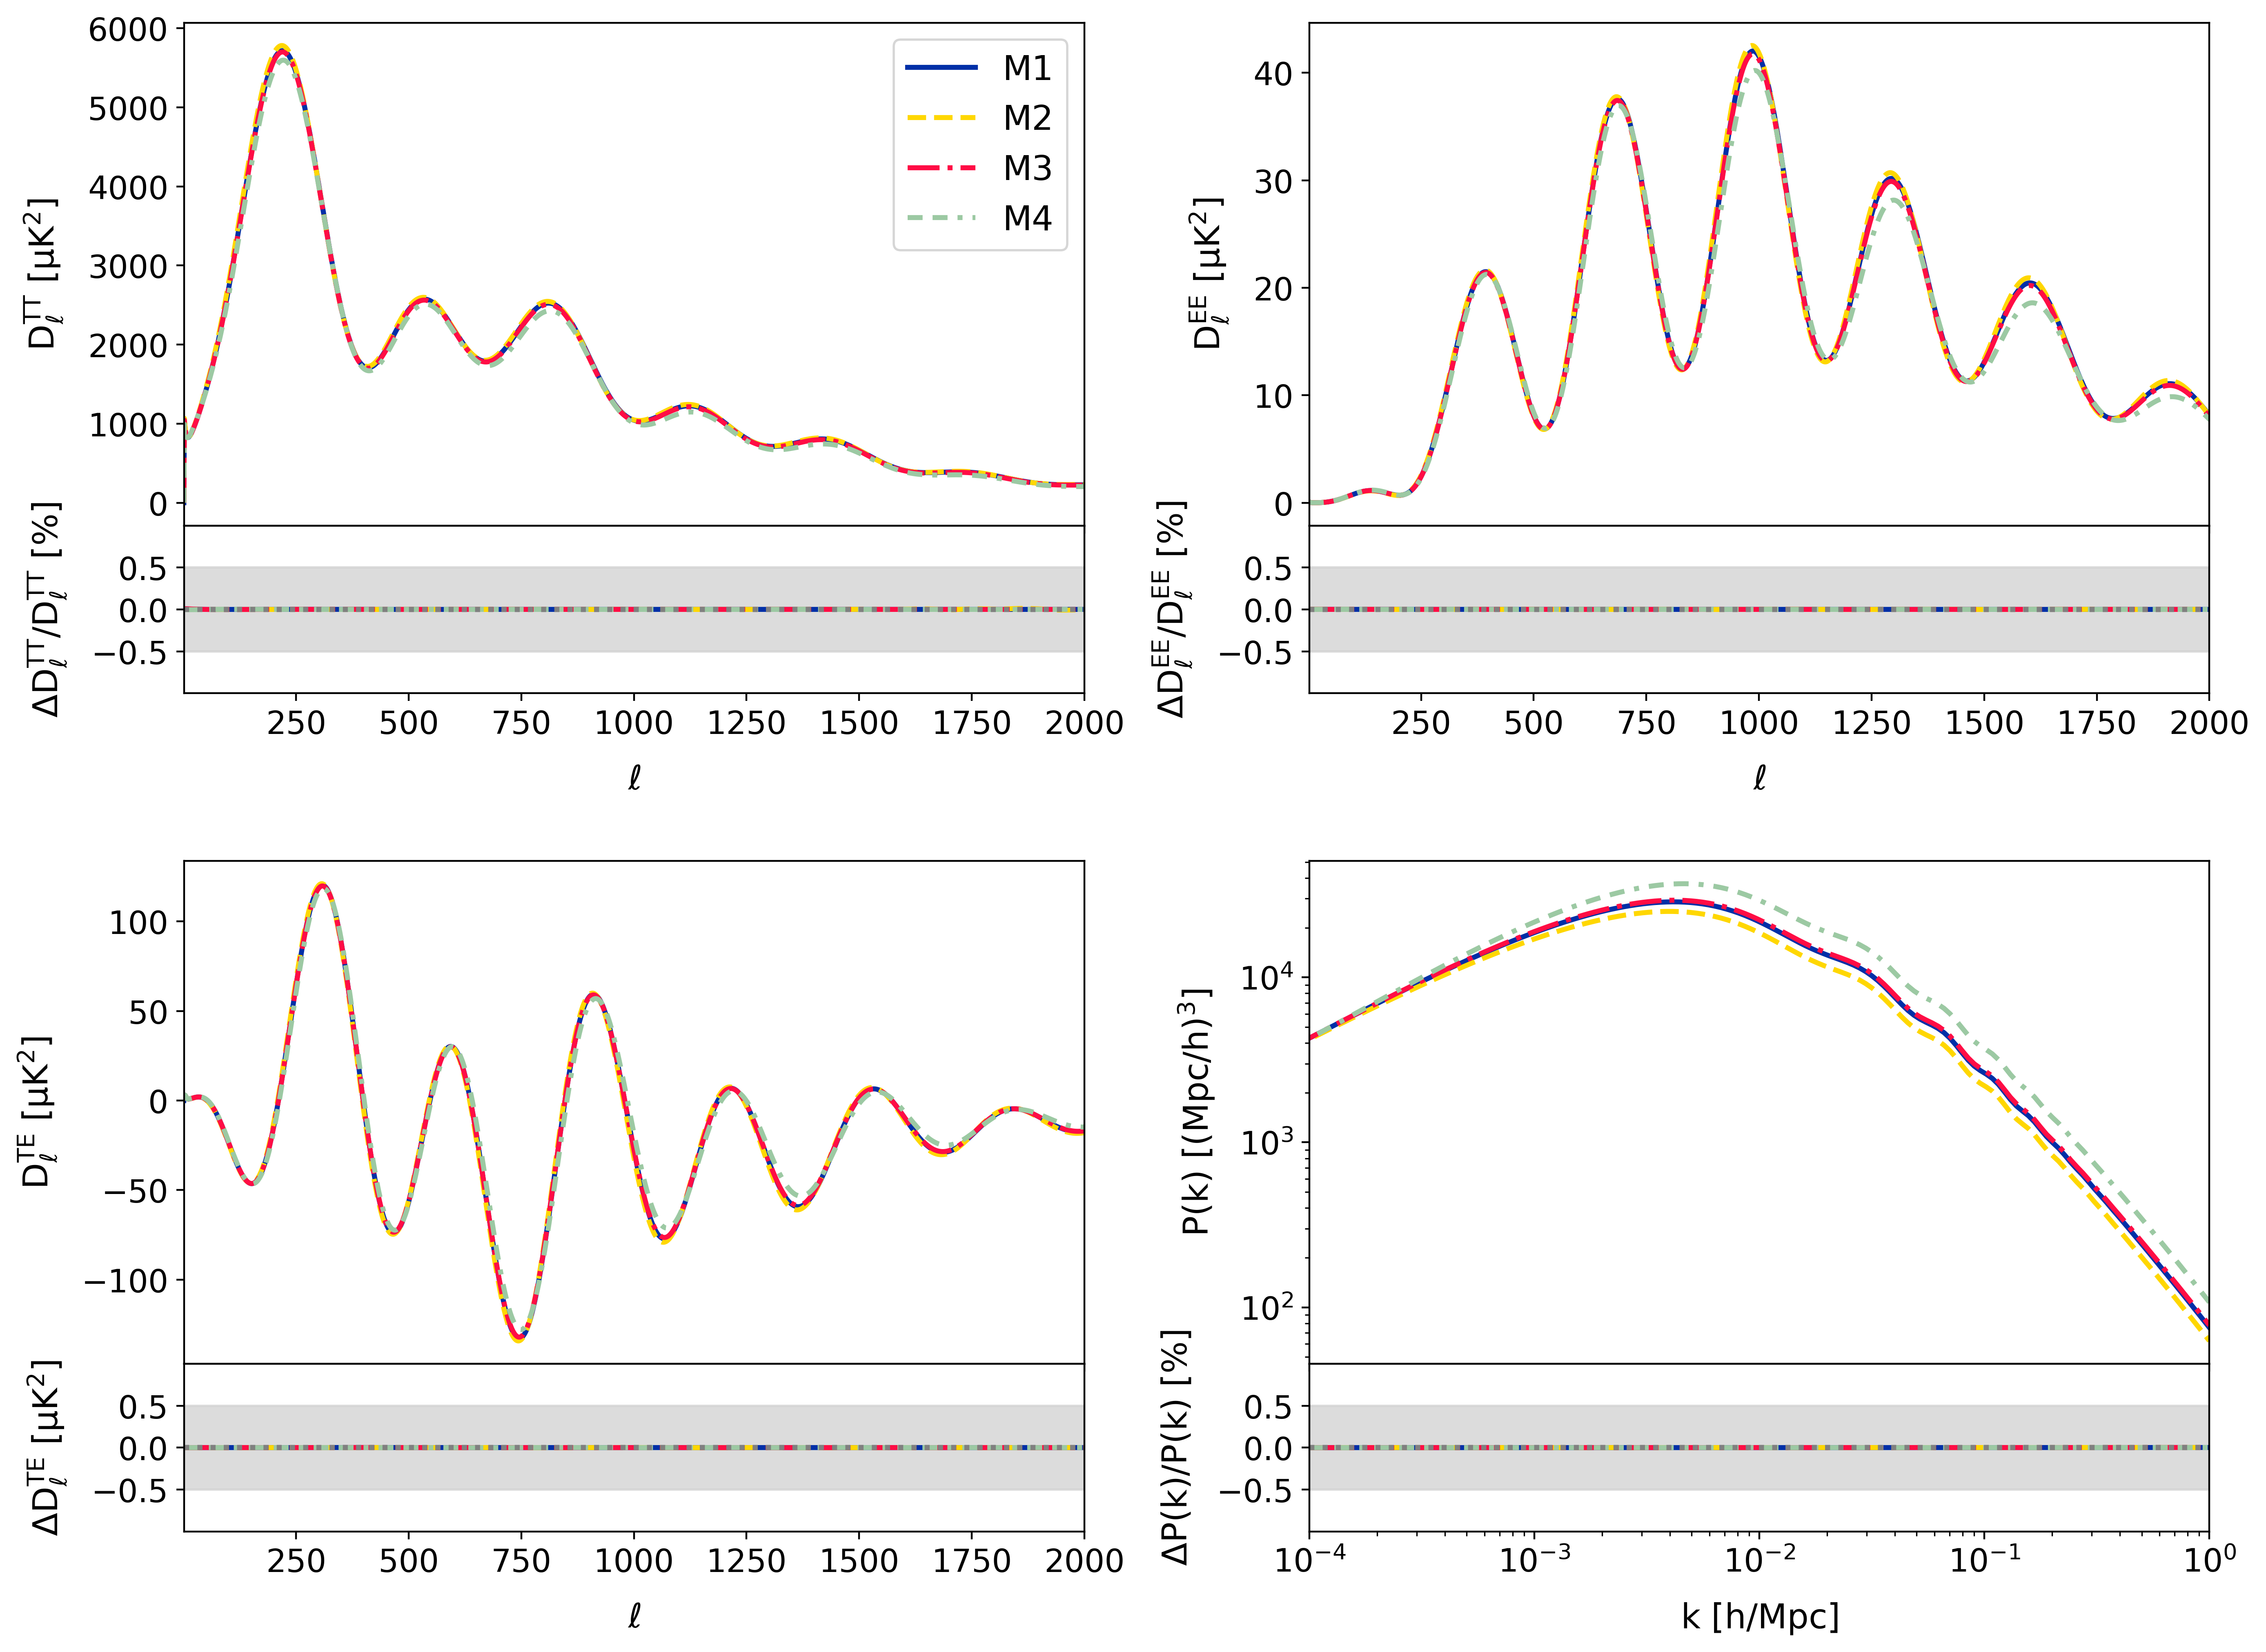

In [21]:
fig = plt.figure(figsize=(16, 12))

outer = gridspec.GridSpec(2, 2, height_ratios=[3, 3], wspace=0.25, hspace=0.25)

gs_TT = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0, 0],
                                         height_ratios=[3, 1], hspace=0.0)
ax_TT = [fig.add_subplot(gs_TT[i, 0]) for i in range(2)]

gs_EE = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0, 1],
                                         height_ratios=[3, 1], hspace=0.0)
ax_EE = [fig.add_subplot(gs_EE[i, 0]) for i in range(2)]

gs_TE = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1, 0],
                                         height_ratios=[3, 1], hspace=0.0)
ax_TE = [fig.add_subplot(gs_TE[i, 0]) for i in range(2)]

gs_Pk = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1, 1],
                                         height_ratios=[3, 1], hspace=0.0)
ax_Pk = [fig.add_subplot(gs_Pk[i, 0]) for i in range(2)]

axes = [[ax_TT[0], ax_EE[0]],
        [ax_TT[1], ax_EE[1]],
        [ax_TE[0], ax_Pk[0]],
        [ax_TE[1], ax_Pk[1]]]


for (name_HEFT, HEFT_params), (name_SCG, SCGEFT_params), color, label, ls in \
        zip(models_HEFT.items(), models_SCG.items(), colors, DE_labels, linestyles):

    params_HEFT = {**HEFT_params, **cosmo_pars, **common_config}
    params_SCG = {**SCGEFT_params, **cosmo_pars, **common_config}

    rlt = root_scalar(shoot, args=(params_HEFT,), rtol=1e-4, bracket=[0, 1e6], x0=3e4, method="brentq")
    params_HEFT['Horndeski_param6'] = rlt.root
    pars_HEFT = camb.set_params(**params_HEFT)
    # pars_HEFT.Accuracy.IntTolBoost = 4
    results_HEFT = camb.get_results(pars_HEFT)
    powers_HEFT = results_HEFT.get_cmb_power_spectra(pars_HEFT, CMB_unit='muK')
    totCL_HEFT = powers_HEFT['total']
    pars_HEFT.NonLinear = model.NonLinear_none
    pars_HEFT.set_matter_power(redshifts=(0.0,))
    results = results_HEFT
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200, params=pars_HEFT)
    kh_HEFT = kh
    pk_HEFT = pk[0]

    pars_SCG = camb.set_params(**params_SCG)
    results_SCG = camb.get_results(pars_SCG)
    powers_SCG = results_SCG.get_cmb_power_spectra(pars_SCG, CMB_unit='muK')
    totCL_SCG = powers_SCG['total']
    pars_SCG.NonLinear = model.NonLinear_none
    pars_SCG.set_matter_power(redshifts=(0.0,))
    kh, z, pk = results_SCG.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200, params=pars_SCG)
#     kh_SCG = kh
    pk_SCG = np.exp(CubicSpline(np.log(kh), np.log(pk[0]))(np.log(kh_HEFT)))

    l = np.arange(totCL_HEFT.shape[0])

    # ---- TT ----
    axes[0][0].plot(l, totCL_HEFT[:, 0], color=color, ls=ls, label=label)
    axes[0][0].tick_params(labelbottom=False)
    axes[1][0].plot(l, (totCL_HEFT[:, 0] - totCL_SCG[:, 0]) / totCL_SCG[:, 0] * 100, color=color, ls=ls)
    axes[0][0].set_xlim([2, 2000])
    axes[0][0].set_ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
    axes[0][0].legend()
    axes[1][0].set_xlim([2, 2000])
    axes[1][0].set_ylim([-1, 1])
    axes[1][0].set_yticks([-0.5, 0, 0.5]) 
    axes[1][0].axhline(0, color='gray', linestyle=':')
    axes[1][0].axhspan(-0.5, 0.5, color='lightgray', alpha=0.3, zorder=0)
    axes[1][0].set_xlabel(r'$\ell$')
    axes[1][0].set_ylabel(r'$\Delta D_\ell^{TT}/D_\ell^{TT}$ [%]')

    # ---- EE ----
    axes[0][1].plot(l, totCL_HEFT[:, 1], color=color, ls=ls, label=label)
    axes[0][1].tick_params(labelbottom=False)
    axes[1][1].plot(l, (totCL_HEFT[:, 1] - totCL_SCG[:, 1]) / totCL_SCG[:, 1] * 100, color=color, ls=ls)
    axes[0][1].set_xlim([2, 2000])
    axes[0][1].set_ylabel(r'$D_\ell^{EE}$ [$\mu K^2$]')
    axes[1][1].set_xlim([2, 2000])
    axes[1][1].set_ylim([-1, 1])
    axes[1][1].set_yticks([-0.5, 0, 0.5]) 
    axes[1][1].axhline(0, color='gray', linestyle=':')
    axes[1][1].axhspan(-0.5, 0.5, color='lightgray', alpha=0.3, zorder=0)
    axes[1][1].set_xlabel(r'$\ell$')
    axes[1][1].set_ylabel(r'$\Delta D_\ell^{EE}/D_\ell^{EE}$ [%]')

    # ---- TE ----
    axes[2][0].plot(l, totCL_HEFT[:, 3], color=color, ls=ls, label=label)
    axes[2][0].tick_params(labelbottom=False)
    axes[3][0].plot(l, (totCL_HEFT[:, 3] - totCL_SCG[:, 3]), color=color, ls=ls)
    axes[2][0].set_xlim([2, 2000])
    axes[2][0].set_ylabel(r'$D_\ell^{TE}$ [$\mu K^2$]')
    axes[3][0].set_xlim([2, 2000])
    axes[3][0].set_ylim([-1, 1])
    axes[3][0].set_yticks([-0.5, 0, 0.5]) 
    axes[3][0].axhline(0, color='gray', linestyle=':')
    axes[3][0].axhspan(-0.5, 0.5, color='lightgray', alpha=0.3, zorder=0)
    axes[3][0].set_xlabel(r'$\ell$')
    axes[3][0].set_ylabel(r'$\Delta D_\ell^{TE}$ [$\mu K^2$]')

    # ---- P(k) ----
    axes[2][1].loglog(kh_HEFT, pk_HEFT, color=color, ls=ls, label=label)
    axes[2][1].tick_params(labelbottom=False)
    axes[3][1].semilogx(kh_HEFT, (pk_HEFT - pk_SCG) / pk_SCG * 100, color=color, ls=ls)
    axes[2][1].set_xlim([1e-3, 1])
    axes[2][1].set_ylabel(r'$P(k)$ [$(Mpc/h)^3$]')
    axes[3][1].set_xlim([1e-4, 1])
    axes[3][1].set_ylim([-1, 1])
    axes[3][1].set_yticks([-0.5, 0, 0.5]) 
    axes[3][1].axhline(0, color='gray', linestyle=':')
    axes[3][1].axhspan(-0.5, 0.5, color='lightgray', alpha=0.3, zorder=0)
    axes[3][1].set_xlabel(r'$k$ [$h/Mpc$]')
    axes[3][1].set_ylabel(r'$\Delta P(k)/P(k)$ [%]')

plt.tight_layout()
plt.show()